In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import einsum
from einops import rearrange, reduce, repeat
import numpy as np
import mlab_tests
from utils import * # MLAB-specific utils library. Contains useful functions like itpeek(tensor)
from typing import *
from days import training_tests
import matplotlib.pyplot as plt
import tqdm

from PIL import Image
from torchvision import transforms
import einops

In [2]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#layer norm

class LayerNorm(nn.Module):
    def __init__(self, reduce_dims, input_shape):
        super().__init__()
        # weights are same order as input to make broadcasting easier
        self.weight_shape = tuple(size if dim in reduce_dims else 1 for dim, size in enumerate(list(input_shape)))
        self.weight = nn.Parameter(t.rand(self.weight_shape))
        self.bias = nn.Parameter(t.rand(self.weight_shape))
        self.reduce_dims = reduce_dims

    def forward(self, input):
        normed = input - input.mean(dim=self.reduce_dims, keep_dim = True)
        normed /= normed.std(dim=self.reduce_dims, keep_dim = True)
        return normed * self.weight + self.bias

        





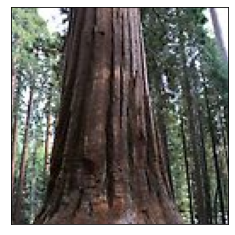

In [13]:
training_tests.plot_image("tree2.jpg")
data_train, data_test =  training_tests.load_image("tree2.jpg")

In [22]:
class MLP3(nn.Module):
    def __init__(self, P, H, K):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(P, H), nn.ReLU(), 
                                    nn.Linear(H, H), nn.ReLU(), 
                                    nn.Linear(H, K))
    def forward(self, input):
        return self.layers(input)

In [6]:
training_tests.test_mlp(MLP3)

Congrats! You've passed the test.


In [7]:
def train(model, training_data, lr, momentum):
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum=momentum)

    for x, y in training_data:
        optimizer.zero_grad()
        y_hat = model(x)
        loss = torch.abs(y - y_hat).mean()
        loss.backward()
        optimizer.step()
    
    return model

In [8]:
training_tests.test_train(train)

Congrats! You've passed the test.


In [9]:
def evaluate(model, data):
    with torch.no_grad():
        losses = []
        for x, y in data:
            y_hat = model(x)
            losses.append(torch.abs(y - y_hat).mean())
        return torch.mean(torch.tensor(losses))

In [10]:
training_tests.test_evaluate(evaluate)

Congrats! You've passed the test.


In [46]:
my_model = MLP3(2, 1000, 3)
train_loss = []
test_loss = []

for _ in range(500):
    my_model = train(my_model, data_train, lr = 0.1, momentum=0.05)
    train_loss.append(evaluate(my_model, data_train))
    test_loss.append(evaluate(my_model, data_test))

    

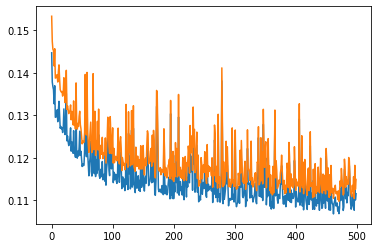

In [47]:
plt.plot(train_loss)
plt.plot(test_loss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


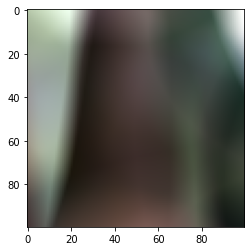

In [48]:
n = 100

coords = torch.linspace(-0.5, 0.5, n)
rows = einops.repeat(coords, "w -> h w", h = n)
cols = einops.repeat(coords, "h -> h w", w = n)
indices = einops.rearrange([rows, cols], "a b c -> (b c) a")
with torch.no_grad():
    outputs = my_model(indices)
    outputs = einops.rearrange(outputs, "(w h) c -> h w c", h = n)
    plt.imshow(outputs + 0.5)
    
    


In [ ]:
def f(x, y, a=1, b=100):
    return (a-x)**2 + b*(y-x**2)**2 + 1

n = 200

rows = einops.repeat(torch.linspace(-2, 2, n), "w -> h w", h = n)
cols = einops.repeat(torch.linspace(-1, 3, n), "h -> h w", w = n)
indices = einops.rearrange([rows, cols], "a b c -> (b c) a")
with torch.no_grad():
    outputs = my_model(indices)
    outputs = einops.rearrange(outputs, "(w h) c -> h w c", h = n)
    plt.imshow(outputs + 0.5)

plt.contourf()